1. **raw데이터 수정**

    처음 raw 데이터를 수정하고 저장한다. 저장한 데이터는 이후 <데이터 다루기>에서 로드한다.

1. **데이터 다루기**

    피쳐를 생성하고 모델에 넣을 수 있게 가공한다.

    1. **피쳐 생성**

        1. 주문
        2. 유저
        3. 제품
        4. 유저별 구매내역

    피쳐를 생성하고 모두 pkl파일로 저장한다. 이후 <생성한 피쳐 통합 후 train/test 분리>에서 로드한다.

    2. **생성한 피쳐 통합 후 train/test 분리**

        train_df와 test_df로 저장한다. 이후 <학습/예측/평가>에서 로드한다.

2. **학습/예측/평가**

    1. 베이스라인
    2. 파라미터 조정 (예정)



# 1. raw데이터 수정하고 pkl로 저장





- **EDA할 때 사용**
1. 모든 구매내역 사용 (prior과 train) : total_df.pkl


- **데이터 생성 시 사용**
1. prior 구매내역만 사용 : prior_df.pkl

    order_product__prior에 products, aisles, departments, orders를 추가한다. 

    orders에 days_since_prior_order 결측치는 -1로 채워서 병합한다.

3. produts : products.pkl

    products에 aisle과 department를 병합해서 저장.

4. orders : orders.pkl

    orders에서 컬럼 순서 변경, days_since_prior_order 결측치 -1로 채우기

5. train : train_products.pkl

    order_product__train에 user_id만 추가 

In [ ]:
import pandas as pd

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(PATH + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             # 3가지
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(PATH + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21
aisles = pd.read_csv(PATH + 'aisles.csv', dtype={
        'product_id': np.uint16})     # 1 ~ 49688
departments = pd.read_csv(PATH + 'departments.csv', dtype={
        'product_id': np.uint16})
train = pd.read_csv(PATH + 'order_products__train.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1

## 모든 구매내역 사용

In [ ]:
df = priors.append(train)
df = df.merge(products, on='product_id', how='left')
df = df.merge(aisles, on='aisle_id', how='left')
df = df.merge(departments, on='department_id', how='left')
df = df.merge(orders, on='order_id', how='outer')
df = df.astype({'product_id': np.float32, 'add_to_cart_order': np.float32, 'reordered': np.float32, 
                'aisle_id': np.float32,'department_id':np.float32, 'product_name' : 'category', 
                'aisle' : 'category', 'department' : 'category'})
col = ['user_id', 'order_number', 'order_id', 'product_id', 'product_name', 'add_to_cart_order', 'reordered', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle_id', 'aisle', 'department_id', 'department', 'eval_set']
df = df[col]
df.sort_values(by=['user_id', 'order_number'], inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33894106 entries, 0 to 33894105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 uint32  
 1   order_number            uint8   
 2   order_id                uint32  
 3   product_id              float32 
 4   product_name            category
 5   add_to_cart_order       float32 
 6   reordered               float32 
 7   order_dow               uint8   
 8   order_hour_of_day       uint8   
 9   days_since_prior_order  float32 
 10  aisle_id                float32 
 11  aisle                   category
 12  department_id           float32 
 13  department              category
 14  eval_set                category
dtypes: category(4), float32(6), uint32(2), uint8(3)
memory usage: 1.4 GB


In [ ]:
df.isnull().sum()

user_id                         0
order_number                    0
order_id                        0
product_id                  75000
product_name                75000
add_to_cart_order           75000
reordered                   75000
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
aisle_id                    75000
aisle                       75000
department_id               75000
department                  75000
eval_set                        0
dtype: int64

하나로 합친 df 저장

In [ ]:
df.to_pickle(PATH + 'total_df.pkl')

## prior 구매내역만 사용

In [ ]:
df = priors.merge(products, on='product_id', how='left')
df = df.merge(aisles, on='aisle_id', how='left')
df = df.merge(departments, on='department_id', how='left')
orders = orders.replace(np.nan, -1).astype({'days_since_prior_order':np.int8}) # 결측치 -1로 채우고 int8로 타입 변환
df = df.merge(orders, on='order_id', how='left')
df = df.astype({'product_name' : 'category', 'aisle' : 'category', 'department' : 'category'})
df.sort_values(by=['user_id', 'order_number'], inplace=True, ignore_index=True)
df['user_buy_product_times'] = df.groupby(['user_id', 'product_id']).cumcount() + 1 # 유저별 제품 누적합 피쳐 생성
col = ['user_id', 'order_number', 'product_name', 'user_buy_product_times', 'add_to_cart_order', 'reordered', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'order_id', 'product_id', 'aisle_id', 'aisle', 'department_id', 'department', 'eval_set']
df = df[col]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 16 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   user_id                 uint32  
 1   order_number            uint8   
 2   product_name            category
 3   user_buy_product_times  int64   
 4   add_to_cart_order       uint8   
 5   reordered               uint8   
 6   order_dow               uint8   
 7   order_hour_of_day       uint8   
 8   days_since_prior_order  int8    
 9   order_id                uint32  
 10  product_id              uint16  
 11  aisle_id                uint8   
 12  aisle                   category
 13  department_id           uint8   
 14  department              category
 15  eval_set                category
dtypes: category(4), int64(1), int8(1), uint16(1), uint32(2), uint8(7)
memory usage: 1.0 GB


In [ ]:
df.head()

,user_id,order_number,product_name,user_buy_product_times,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,order_id,product_id,aisle_id,aisle,department_id,department,eval_set
0,1,1,Soda,1,1,0,2,8,-1,2539329,196,77,soft drinks,7,beverages,prior
1,1,1,Organic Unsweetened Vanilla Almond Milk,1,2,0,2,8,-1,2539329,14084,91,soy lactosefree,16,dairy eggs,prior
2,1,1,Original Beef Jerky,1,3,0,2,8,-1,2539329,12427,23,popcorn jerky,19,snacks,prior
3,1,1,Aged White Cheddar Popcorn,1,4,0,2,8,-1,2539329,26088,23,popcorn jerky,19,snacks,prior
4,1,1,XL Pick-A-Size Paper Towel Rolls,1,5,0,2,8,-1,2539329,26405,54,paper goods,17,household,prior


In [ ]:
df.isnull().sum()

user_id                   0
order_number              0
product_name              0
user_buy_product_times    0
add_to_cart_order         0
reordered                 0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
order_id                  0
product_id                0
aisle_id                  0
aisle                     0
department_id             0
department                0
eval_set                  0
dtype: int64

하나로 합친 df 저장

In [ ]:
df.to_pickle(PATH + 'prior_df.pkl')

## products

In [ ]:
prod = products.merge(aisles, on='aisle_id', how='left').merge(departments, on='department_id', how='left')
prod = prod[['product_id', 'product_name', 'aisle', 'department', 'aisle_id', 'department_id']]
prod

,product_id,product_name,aisle,department,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,61,19
1,2,All-Seasons Salt,spices seasonings,pantry,104,13
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen,38,1
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry,5,13
...,...,...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",spirits,alcohol,124,5
49684,49685,En Croute Roast Hazelnut Cranberry,frozen vegan vegetarian,frozen,42,1
49685,49686,Artisan Baguette,bread,bakery,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,cat food care,pets,41,8


In [ ]:
prod.to_pickle(PATH + 'products.pkl')

## orders

In [ ]:
orders = orders.replace(np.nan, -1).astype({'days_since_prior_order':np.int8}) # 결측치 -1로 채우고 int8로 타입 변환
orders = orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'eval_set', 'order_id']]
orders

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set,order_id
0,1,1,2,8,-1,prior,2539329
1,1,2,3,7,15,prior,2398795
2,1,3,3,12,21,prior,473747
3,1,4,4,7,29,prior,2254736
4,1,5,4,15,28,prior,431534
...,...,...,...,...,...,...,...
3421078,206209,10,5,18,29,prior,2266710
3421079,206209,11,4,10,30,prior,1854736
3421080,206209,12,1,12,18,prior,626363
3421081,206209,13,1,12,7,prior,2977660


In [ ]:
orders.to_pickle(PATH + 'orders.pkl')

## train

In [ ]:
tr = train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
tr

,order_id,product_id,add_to_cart_order,reordered,user_id
0,1,49302,1,1,112108
1,1,11109,2,1,112108
2,1,10246,3,0,112108
3,1,49683,4,0,112108
4,1,43633,5,1,112108
...,...,...,...,...,...
1384612,3421063,14233,3,1,169679
1384613,3421063,35548,4,1,169679
1384614,3421070,35951,1,1,139822
1384615,3421070,16953,2,1,139822


In [ ]:
tr.to_pickle(PATH + 'train_products.pkl')

# 2. 데이터 다루기


생성한 데이터 프레임
1. 주문
2. 유저
3. 제품
4. 유저 구매내역

생성한 데이터 프레임 합치고 train, test 셋으로 분할

### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.5)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [2]:
# prior 구매내역 가져오기
df = pd.read_pickle(PATH + 'prior_df.pkl')
products = pd.read_pickle(PATH + 'products.pkl')
# train, test 정보를 위해서 불러오기
orders = pd.read_pickle(PATH + 'orders.pkl')
train = pd.read_pickle(PATH + 'train_products.pkl')

In [3]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [18]:
df.head(10)

,user_id,order_number,product_name,user_buy_product_times,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,order_id,product_id,aisle_id,aisle,department_id,department,eval_set
0,1,1,Soda,1,1,0,2,8,-1,2539329,196,77,soft drinks,7,beverages,prior
1,1,1,Organic Unsweetened Vanilla Almond Milk,1,2,0,2,8,-1,2539329,14084,91,soy lactosefree,16,dairy eggs,prior
2,1,1,Original Beef Jerky,1,3,0,2,8,-1,2539329,12427,23,popcorn jerky,19,snacks,prior
3,1,1,Aged White Cheddar Popcorn,1,4,0,2,8,-1,2539329,26088,23,popcorn jerky,19,snacks,prior
4,1,1,XL Pick-A-Size Paper Towel Rolls,1,5,0,2,8,-1,2539329,26405,54,paper goods,17,household,prior
5,1,2,Soda,2,1,1,3,7,15,2398795,196,77,soft drinks,7,beverages,prior
6,1,2,Pistachios,1,2,0,3,7,15,2398795,10258,117,nuts seeds dried fruit,19,snacks,prior
7,1,2,Original Beef Jerky,2,3,1,3,7,15,2398795,12427,23,popcorn jerky,19,snacks,prior
8,1,2,Bag of Organic Bananas,1,4,0,3,7,15,2398795,13176,24,fresh fruits,4,produce,prior
9,1,2,Aged White Cheddar Popcorn,2,5,1,3,7,15,2398795,26088,23,popcorn jerky,19,snacks,prior


## ✅ 주문별 정보

### 정보

#### 생성한 컬럼
- items : 제품 수
- reorder_in_order : 재주문 제품 비율

마지막 3개 주문 뽑기

#### 아이디어
- 주문별 대분류, 소분류 정보 사용하기

### 데이터

In [24]:
order_feats = df.groupby(['user_id','order_number']).agg(items=('product_id','count'), 
                                                         reorder_in_order=('reordered', 'mean'))
order_feats.reset_index(inplace=True)
order_feats = orders.merge(order_feats, on=['user_id','order_number'], how='left')
col = order_feats.columns[:2].to_list() + order_feats.columns[-2:].to_list() + order_feats.columns[2:-2].to_list()
order_feats = order_feats[col]
order_feats.days_since_prior_order.fillna(-1, inplace=True) # 재주문 기간 결측치는 -1로 채운다.
order_feats = order_feats.astype({'days_since_prior_order': np.int8})
print(order_feats.shape)
order_feats.head()

(3421083, 9)


,user_id,order_number,items,reorder_in_order,order_dow,order_hour_of_day,days_since_prior_order,eval_set,order_id
0,1,1,5.0,0.000,2,8,-1,prior,2539329
1,1,2,6.0,0.500,3,7,15,prior,2398795
2,1,3,5.0,0.600,3,12,21,prior,473747
3,1,4,5.0,1.000,4,7,29,prior,2254736
4,1,5,8.0,0.625,4,15,28,prior,431534


In [25]:
# 마지막 주문 3개 뽑기
last_three_orders = order_feats[order_feats.eval_set == 'prior'].sort_values('order_number', ascending=False)\
                    .groupby('user_id').head(3).sort_values(['user_id', 'order_number'], ignore_index=True)
last_three_orders['rank'] = last_three_orders.groupby('user_id')['order_number'].rank()
print(last_three_orders.shape)
last_three_orders.head()

(618627, 10)


,user_id,order_number,items,reorder_in_order,order_dow,order_hour_of_day,days_since_prior_order,eval_set,order_id,rank
0,1,8,6.0,0.666667,1,14,14,prior,3108588,1.0
1,1,9,6.0,1.000000,1,16,0,prior,2295261,2.0
2,1,10,9.0,0.666667,4,8,30,prior,2550362,3.0
3,2,12,19.0,0.578947,1,9,28,prior,3186735,1.0
4,2,13,9.0,0.000000,4,11,30,prior,3268552,2.0


### 분석

#### 재주문 기간에 따른 주문별 재주문 제품 비율

재주문 기간 0과 7일 때 재주문 제품 비율이 가장 높다. 0은 당일 재주문을 의미한다. 

당일과 7일이후 재주문을 한다면 이전에 구매한 제품을 구매할 확률이 높다. 

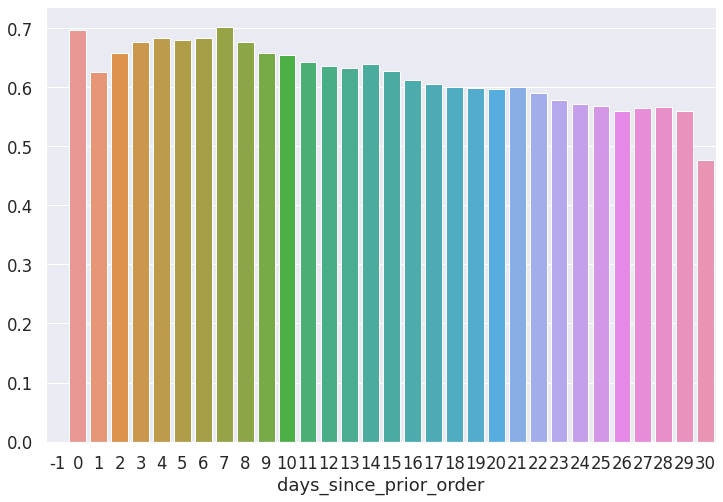

In [ ]:
data = order_feats.groupby('days_since_prior_order')['reorder_in_order'].mean()

plt.figure(figsize=(12, 8))
sns.barplot(x=data.index, y=data.values)
plt.show()

## ✅ 유저별

### 정보

#### 생성한 컬럼

- total_orders : 총 주문 수
- total_products : 총 구매 제품 수
- unique_products : 총 구매 제품 종류 수
- total_reorders : 총 재주문 수
- unique_reordered_items : 총 재주문 제품 종류 수
- avg_items_in_order : 주문당 평균 구매 제품 수
- avg_reorder_in_order : 주문당 평균 재구매 제품 비율
- 마지막 3개의 주문 구매 제품 수, 재주문 제품 포함 비율

#### 아이디어

- 주문 요일, 시간, 재주문 기간을 사용하기

### 데이터

In [26]:
user_feats = df.groupby('user_id').agg(U_total_orders=('order_number', 'max'), 
                                  U_total_products=('product_id', 'count'), 
                                  U_unique_products=('product_id', 'nunique'),
                                  U_total_reorders=('reordered', 'sum'))
user_feats.reset_index(inplace=True)

# 재구매 제품 종류수
unique_re_items = df[df.reordered == 1].drop_duplicates(['user_id', 'product_name']).groupby('user_id')['product_name'].nunique()\
                    .reset_index().rename(columns={'product_name': 'U_unique_reordered_items'})
user_feats = user_feats.merge(unique_re_items, on='user_id', how='left')
user_feats['U_unique_reordered_items'].fillna(0, inplace=True)

user_feats['U_avg_items_in_order'] = order_feats.groupby('user_id')['items'].mean().values
user_feats['U_avg_reorder_in_order'] = order_feats[order_feats['order_number'] != 1].groupby('user_id')['reorder_in_order'].mean().values

# 마지막 3개의 주문 정보 추가
# 마지막 주문이 1이다. 슬라이싱할 때 [-1]느낌
last_order_feats = last_three_orders.pivot_table(index = 'user_id', columns = ['rank'], \
                                                 values=['items', 'reorder_in_order']).\
                                                reset_index(drop = False)
last_order_feats.columns = ['user_id','prod_order_3', 'U_prod_order_2', 'U_prod_order_1', 'U_re_in_order_3', 'U_re_in_order_2', 'U_re_in_order_1']
user_feats = user_feats.merge(last_order_feats, on='user_id', how='left')

print(user_feats.shape)
user_feats.head()

(206209, 14)


,user_id,U_total_orders,U_total_products,U_unique_products,U_total_reorders,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1
0,1,10,59,18,41.0,10.0,5.900000,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
1,2,14,195,102,93.0,37.0,13.928571,0.482419,19.0,9.0,16.0,0.578947,0.0,0.625000
2,3,12,88,33,55.0,19.0,7.333333,0.718710,6.0,5.0,6.0,0.833333,1.0,1.000000
3,4,5,18,17,1.0,1.0,3.600000,0.035714,7.0,2.0,3.0,0.142857,0.0,0.000000
4,5,4,37,23,14.0,8.0,9.250000,0.503704,9.0,5.0,12.0,0.444444,0.4,0.666667


In [ ]:
# pkl로 저장
user_feats.to_pickle(PATH + 'user_feats.pkl')

## ✅ 제품별

### 정보

전체 주문 제품 통계

#### 생성한 컬럼

- total_orders : 총 판매 수 
- unique_users : 구매한 유저 수
- total_reorders : 총 재주문 수 
- reorder_rate : 재주문 율
- mean_cart_order : 평균 장바구니 순위

#### 아이디어

- 소분류, 대분류 정보 사용하기
- 제품, 소분류, 대분류 별 주문 시간,요일,재주문 기간 정보 사용해보기
- low fat과 organic의 재구매율 확인해보기

### 데이터

In [4]:
prod_feats = df.groupby('product_name').agg(P_total_orders=('product_id', 'count'), 
                                            P_unique_users=('user_id','nunique'), 
                                            P_total_reorders=('reordered', 'sum'), 
                                            P_reorder_rate=('reordered', 'mean'), 
                                            P_mean_cart_order=('add_to_cart_order', 'mean'), 
                                            is_organic=('product_name', lambda x: 1 if 'Organic' in x else 0), 
                                            is_low_fat=('product_name', lambda x: 1 if 'Lowfat' in x else 0))
prod_feats = prod_feats.merge(products, on='product_name', how='left') # prior 구매내역에 있는 없는 11개의 제품은 사라진다.
prod_feats.sort_values(by='P_total_orders', inplace=True, ascending=False, ignore_index=True)
prod_feats

,product_name,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,is_organic,is_low_fat,product_id,aisle,department,aisle_id,department_id
0,Banana,472565,73956,398609.0,0.843501,4.894129,0,0,24852,fresh fruits,produce,24,4
1,Bag of Organic Bananas,379450,63537,315913.0,0.832555,5.095947,0,0,13176,fresh fruits,produce,24,4
2,Organic Strawberries,264683,58838,205845.0,0.777704,7.248902,0,0,21137,fresh fruits,produce,24,4
3,Organic Baby Spinach,241921,55037,186884.0,0.772500,7.429640,0,0,21903,packaged vegetables fruits,produce,123,4
4,Organic Hass Avocado,213584,43453,170131.0,0.796553,6.775011,0,0,47209,fresh fruits,produce,24,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49672,Pure Performance Restorative Shampoo Chamomile...,1,1,0.0,0.000000,2.000000,0,0,26117,hair care,personal care,22,11
49673,Lindor Peppermint White Chocolate Truffles,1,1,0.0,0.000000,20.000000,0,0,35542,candy chocolate,snacks,45,19
49674,Dynostix Rawhide Chew With Meat,1,1,0.0,0.000000,8.000000,0,0,30068,dog food care,pets,40,8
49675,Max White With Polishing Star Soft Toothbrush,1,1,0.0,0.000000,14.000000,0,0,26627,oral hygiene,personal care,20,11


#### 소분류 & 대분류 정보 추가

aisle 정보 생성

- aisle_total_orders : 총 구매 수
- aisle_total_reorders : 총 재구매 수
- aisle_reorder_rate : 재주문 율
- aisle_avg_cart_order : 평균 장바구니 순위



In [5]:
agg_dict2 = {'reordered' : ['count','sum','mean'], 
             'add_to_cart_order' : 'mean'}

col2 = ['aisle_total_orders', 'aisle_total_reorders', 'aisle_reorder_rate', 'aisle_avg_cart_order']

aisle_feats = df.groupby('aisle')b.agg(agg_dict2)
aisle_feats.columns = col2
aisle_feats.sort_values(by='aisle_total_orders', inplace=True, ascending=False)
aisle_feats.reset_index(inplace=True)
aisle_feats.head()

,aisle,aisle_total_orders,aisle_total_reorders,aisle_reorder_rate,aisle_avg_cart_order
0,fresh fruits,3642188,2615469.0,0.718104,7.144228
1,fresh vegetables,3418021,2032172.0,0.594546,8.852012
2,packaged vegetables fruits,1765313,1127177.0,0.638514,8.399527
3,yogurt,1452343,997018.0,0.686489,7.861644
4,packaged cheese,979763,573383.0,0.585226,9.078364


department 정보 생성

- department_total_orders : 총 구매 수
- department_total_reorders : 총 재구매 수
- department_reorder_rate : 재주문 율
- department_avg_cart_order : 평균 장바구니 순위



In [6]:
agg_dict3 = {'reordered' : ['count','sum','mean'], 
             'add_to_cart_order' : 'mean'}

col3 = ['department_total_orders', 'department_total_reorders', 'department_reorder_rate', 'department_avg_cart_order']

dp_feats = df.groupby('department').agg(agg_dict3)
dp_feats.columns = col3
dp_feats.sort_values(by='department_total_orders', inplace=True, ascending=False)
dp_feats.reset_index(inplace=True)
dp_feats.head()

,department,department_total_orders,department_total_reorders,department_reorder_rate,department_avg_cart_order
0,produce,9479291,6160710.0,0.649913,8.022875
1,dairy eggs,5414016,3627221.0,0.669969,7.495423
2,snacks,2887550,1657973.0,0.574180,9.187743
3,beverages,2690129,1757892.0,0.653460,6.976699
4,frozen,2236432,1211890.0,0.541885,8.996414


제품 정보에 병합

In [7]:
prod_feats = prod_feats.merge(aisle_feats, on='aisle', how='left')
prod_feats = prod_feats.merge(dp_feats, on='department', how='left')
prod_feats.head()

,product_name,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,is_organic,is_low_fat,product_id,aisle,...,aisle_id,department_id,aisle_total_orders,aisle_total_reorders,aisle_reorder_rate,aisle_avg_cart_order,department_total_orders,department_total_reorders,department_reorder_rate,department_avg_cart_order
0,Banana,472565,73956,398609.0,0.843501,4.894129,0,0,24852,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
1,Bag of Organic Bananas,379450,63537,315913.0,0.832555,5.095947,0,0,13176,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
2,Organic Strawberries,264683,58838,205845.0,0.777704,7.248902,0,0,21137,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
3,Organic Baby Spinach,241921,55037,186884.0,0.772500,7.429640,0,0,21903,packaged vegetables fruits,...,123,4,1765313,1127177.0,0.638514,8.399527,9479291,6160710.0,0.649913,8.022875
4,Organic Hass Avocado,213584,43453,170131.0,0.796553,6.775011,0,0,47209,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875


In [14]:
# pkl로 저장
prod_feats.to_pickle(PATH + 'prod_feats.pkl')

### 분석






구매예측에 도움이 될 만한 것.

- 가장 많이 팔린 제품
- 판매량과 재구매율

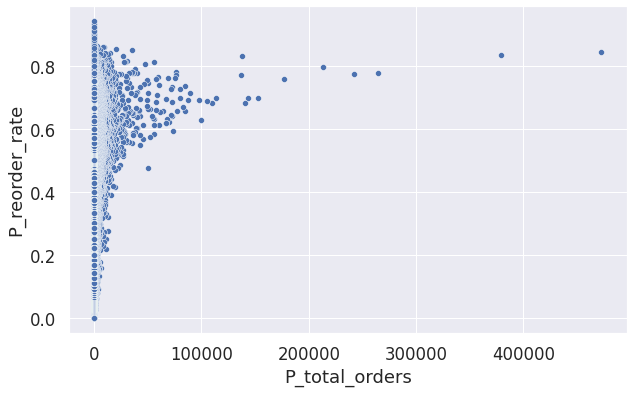

In [12]:
# 제품별 판매량과 재구매율
plt.figure(figsize=(10, 6))
sns.scatterplot(x='P_total_orders', y='P_reorder_rate', data=prod_feats)
plt.show()

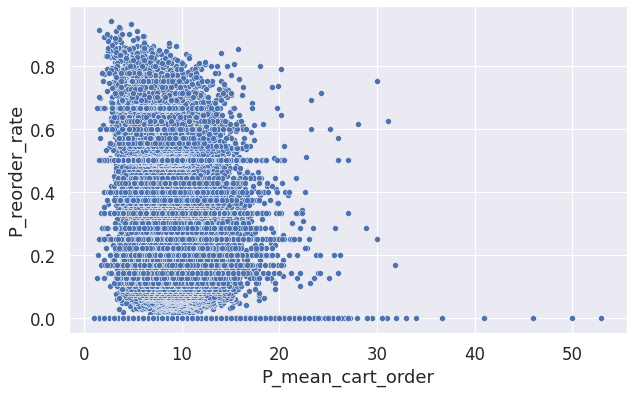

In [13]:
# 장바구니 순위와 재구매율
plt.figure(figsize=(10, 6))
sns.scatterplot(x='P_mean_cart_order', y='P_reorder_rate', data=prod_feats)
plt.show()

## ✅ 유저별 구매내역

### 정보

유저별 구매 내역 제품 통계

#### 생성한 컬럼

- total_reorders : 총 재주문 수
- UP_reorder_ratio : 해당 제품을 처음 구매한 이후 재주문이 가능한 기간(주문 수)동안의 재주문 율
    - user_total_orders : 유저의 총 주문 수
    - first_order_num : 해당 제품의 첫번째 주문 순서
    - total_reorders : 총 재주문 수

- last_order_num : 해당 제품의 마지막 주문 순서
- mean_cart_order : 평균 장바구니 순위

- order-3,2,1 : 마지막 3번의 주문에서 재주문 여부 (구매 된적이 없다면 -1)

#### 아이디어

- 제품, 소분류, 대분류 별 주문 시간,요일,재주문 기간 정보 사용해보기

In [45]:
user_prod_feats = df.groupby(['user_id', 'product_id']).agg(UP_total_reorders=('reordered', 'sum'),
                                                            UP_first_order_num=('order_number', 'min'),
                                                            UP_mean_cart_order=('add_to_cart_order', 'mean'))
user_prod_feats.reset_index(inplace=True)


# 마지막 3개 주문 구매내역 추가
# 1. 마지막 3개 주문 내역 뽑기
last_three_orders_prods = df.merge(last_three_orders[['user_id', 'order_number']], on=['user_id', 'order_number'], how='inner')
last_three_orders_prods['rank'] = last_three_orders_prods.groupby(['user_id', 'product_id'])['order_number'].rank()
# 2. 제품 별로 마지막 3개 주문에서 재주문 여부 뽑기 
product_purchase_history = last_three_orders_prods.pivot_table(index = ['user_id', 'product_id'],\
                                                   columns='rank', values = 'reordered')
product_purchase_history.columns = ['UP_order_-3', 'UP_order_-2', 'UP_order_-1']
product_purchase_history.reset_index(inplace=True)
# 3. 병합
user_prod_feats = user_prod_feats.merge(product_purchase_history, on=['user_id', 'product_id'], how='left')
user_prod_feats = user_prod_feats.replace(np.nan, -1)    # 마지막 3개의 주문에서 판매된 적 없다면 결측치이다. -1로 채운다.

# 재주문율 뽑기
# 1. 유저 별 총 주문 수 추가
user_prod_feats = user_prod_feats.merge(df.drop_duplicates('user_id', keep='last')[['user_id', 'order_number']].rename(columns={'order_number':'user_total_orders'}), on='user_id', how='left')
# 2. 재주문 가능 주문 수 뽑기
user_prod_feats['order_range_D'] = user_prod_feats.user_total_orders - user_prod_feats.UP_first_order_num
# 3. 재주문 율 뽑기
user_prod_feats['UP_reorder_ratio'] = user_prod_feats.UP_total_reorders / user_prod_feats['order_range_D']
user_prod_feats.UP_reorder_ratio.fillna(0, inplace=True)
user_prod_feats.drop(['user_total_orders', 'UP_first_order_num', 'order_range_D'], axis=1, inplace=True)


# 제품 정보 추가
user_prod_feats = user_prod_feats.merge(df.drop_duplicates('product_id')[['product_id', 'product_name', 'aisle', 'department', 'aisle_id', 'department_id']], on='product_id', how='left')
# 재구매 수 내림차순 정렬
user_prod_feats.sort_values(['user_id', 'UP_total_reorders'], ascending=[True, False], ignore_index=True, inplace=True)

# 데이터 타입 변경으로 메모리 줄이기
user_prod_feats = user_prod_feats.astype({'UP_mean_cart_order':np.float32, 
                                          'UP_order_-3': np.int8, 
                                          'UP_order_-2': np.int8, 
                                          'UP_order_-1': np.int8, 
                                          'UP_reorder_ratio': np.float32})
print(user_prod_feats.shape)
user_prod_feats.head()

(13307953, 13)


,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,product_name,aisle,department,aisle_id,department_id
0,1,196,9,1.400000,1,1,1,1.00,Soda,soft drinks,beverages,77,7
1,1,12427,9,3.300000,1,1,1,1.00,Original Beef Jerky,popcorn jerky,snacks,23,19
2,1,10258,8,3.333333,1,1,1,1.00,Pistachios,nuts seeds dried fruit,snacks,117,19
3,1,25133,7,4.000000,1,1,1,1.00,Organic String Cheese,packaged cheese,dairy eggs,21,16
4,1,13032,2,6.333333,1,-1,-1,0.25,Cinnamon Toast Crunch,cereal,breakfast,121,14


In [ ]:
user_prod_feats.isnull().sum()

In [ ]:
user_prod_feats.info()

In [47]:
# pkl로 저장
user_prod_feats.to_pickle(PATH + 'user_prod_feats.pkl')

## 생성한 피쳐 통합 후 train/test 분리

모델에 바로 넣을 수 있는 형태로 데이터를 가공한다.

In [1]:
# 위에서 생성한 피쳐 가져오기
import numpy as np
import pandas as pd

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

user_feats = pd.read_pickle(PATH + 'user_feats.pkl')
prod_feats = pd.read_pickle(PATH + 'prod_feats.pkl')
user_prod_feats = pd.read_pickle(PATH + 'user_prod_feats.pkl')
orders = pd.read_pickle(PATH + 'orders.pkl')
train = pd.read_pickle(PATH + 'train_products.pkl')

In [2]:
def reduce_memory(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            cmin = df[col].min()
            cmax = df[col].max()
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        if df[col].dtypes in ["float64", "float32"]:
            cmin = df[col].min()
            cmax = df[col].max()
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df

In [3]:
# 마지막 주문 정보 추가 (요일, 시간, 재주문 기간)
prepare_df = user_prod_feats.merge(orders[orders.eval_set != 'prior'].drop(['order_id', 'eval_set'], axis=1), on='user_id', how='left')
# 훈련시 필요없는 컬럼은 drop
drop_feats = ['product_name', 'aisle', 'department'] 
prepare_df.drop(drop_feats, axis=1, inplace=True)

print(prepare_df.shape)
prepare_df.head(3)

(13307953, 17)


,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,product_name,aisle,department,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196,9,1.400000,1,1,1,1.0,Soda,soft drinks,beverages,77,7,11,4,8,14
1,1,12427,9,3.300000,1,1,1,1.0,Original Beef Jerky,popcorn jerky,snacks,23,19,11,4,8,14
2,1,10258,8,3.333333,1,1,1,1.0,Pistachios,nuts seeds dried fruit,snacks,117,19,11,4,8,14


제품 피쳐와 유저 피쳐를 병합한다. 

In [5]:
prepare_df = prepare_df.merge(prod_feats.drop(['product_name', 'aisle', 'department', 'aisle_id', 'department_id'], axis=1), on='product_id', how='left')
prepare_df = prepare_df.merge(user_feats, on='user_id', how='left')
print(prepare_df.shape)
prepare_df.head()

(13307953, 42)


,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,aisle_id,department_id,...,U_total_reorders,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1
0,1,196,9,1.400000,1,1,1,1.00,77,7,...,41.0,10.0,5.9,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,12427,9,3.300000,1,1,1,1.00,23,19,...,41.0,10.0,5.9,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10258,8,3.333333,1,1,1,1.00,117,19,...,41.0,10.0,5.9,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,25133,7,4.000000,1,1,1,1.00,21,16,...,41.0,10.0,5.9,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,2,6.333333,1,-1,-1,0.25,121,14,...,41.0,10.0,5.9,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667


In [6]:
# 데이터 병합 후 메모리 줄이기
prepare_df = reduce_memory(prepare_df)
prepare_df.info()

Memory usage of properties dataframe is : 3287.0863218307495  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1332.602562904358  MB
This is  40.54054054054054 % of the initial size
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13307953 entries, 0 to 13307952
Data columns (total 42 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    uint64 
 1   product_id                 uint64 
 2   UP_total_reorders          uint8  
 3   UP_mean_cart_order         float16
 4   UP_order_-3                int8   
 5   UP_order_-2                int8   
 6   UP_order_-1                int8   
 7   UP_reorder_ratio           float16
 8   aisle_id                   uint8  
 9   department_id              uint8  
 10  order_number               uint8  
 11  order_dow                  uint8  
 12  order_hour_of_day          uint8  
 13  days_since_prior_order     int8   
 14  P_total_orders             int32  
 15  P_unique

train/test로 분할하기

In [7]:
# 1. train, test 셋 유저 명단 뽑기 
train_users = orders[orders.eval_set == 'train'].user_id.unique() 
test_users = orders[orders.eval_set == 'test'].user_id.unique() 

# 2. train, test set 분리
train_df = prepare_df[prepare_df['user_id'].isin(train_users)]
test_df = prepare_df[prepare_df['user_id'].isin(test_users)]

# 3. train_df에 타겟값 추가
# 마지막 주문에서 해당 제품을 구매했는지 안 했는지 알 수 있다. 
train_df = train_df.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id','product_id'], how='left') 
train_df['reordered'].fillna(0, inplace=True)
train_df = train_df.astype({'reordered': np.uint8})

train_df.sort_values(by=['user_id', 'UP_total_reorders'], ascending=[True, False], inplace=True, ignore_index=True)
train_df.shape, test_df.shape

((8474661, 43), (4833292, 42))

In [8]:
train_df.head()

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,aisle_id,department_id,...,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1,reordered
0,1,196,9,1.400391,1,1,1,1.00,77,7,...,10.0,5.898438,0.78418,6.0,6.0,9.0,0.666504,1.0,0.666504,1
1,1,12427,9,3.300781,1,1,1,1.00,23,19,...,10.0,5.898438,0.78418,6.0,6.0,9.0,0.666504,1.0,0.666504,0
2,1,10258,8,3.333984,1,1,1,1.00,117,19,...,10.0,5.898438,0.78418,6.0,6.0,9.0,0.666504,1.0,0.666504,1
3,1,25133,7,4.000000,1,1,1,1.00,21,16,...,10.0,5.898438,0.78418,6.0,6.0,9.0,0.666504,1.0,0.666504,1
4,1,13032,2,6.332031,1,-1,-1,0.25,121,14,...,10.0,5.898438,0.78418,6.0,6.0,9.0,0.666504,1.0,0.666504,1


In [9]:
train_df.head(3).T

,0,1,2
user_id,1.000000e+00,1.000000e+00,1.000000e+00
product_id,1.960000e+02,1.242700e+04,1.025800e+04
UP_total_reorders,9.000000e+00,9.000000e+00,8.000000e+00
UP_mean_cart_order,1.400391e+00,3.300781e+00,3.333984e+00
UP_order_-3,1.000000e+00,1.000000e+00,1.000000e+00
UP_order_-2,1.000000e+00,1.000000e+00,1.000000e+00
UP_order_-1,1.000000e+00,1.000000e+00,1.000000e+00
UP_reorder_ratio,1.000000e+00,1.000000e+00,1.000000e+00
aisle_id,7.700000e+01,2.300000e+01,1.170000e+02
department_id,7.000000e+00,1.900000e+01,1.900000e+01


생성한 데이터 저장

In [10]:
train_df.to_pickle(PATH + 'train_df.pkl')
test_df.to_pickle(PATH + 'test_df.pkl')

### 분석

- 타겟 분포

0.0    7645837
1.0     828824
Name: reordered, dtype: int64


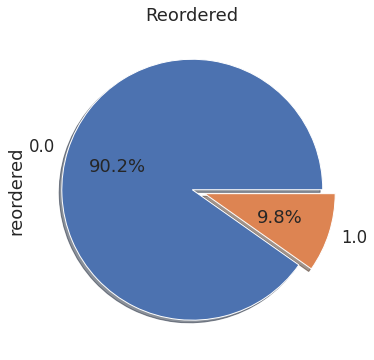

In [ ]:
print(train_priors_prods.reordered.value_counts())

plt.figure(figsize=(8, 6))
train_priors_prods.reordered.value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True)
plt.title('Reordered')
plt.show()

전체 구매한 제품 중 마지막 주문에서 재구매한 제품은 9.8%다.

reordered
0.0    9.308264
1.0    8.305674
Name: mean_cart_order, dtype: float32


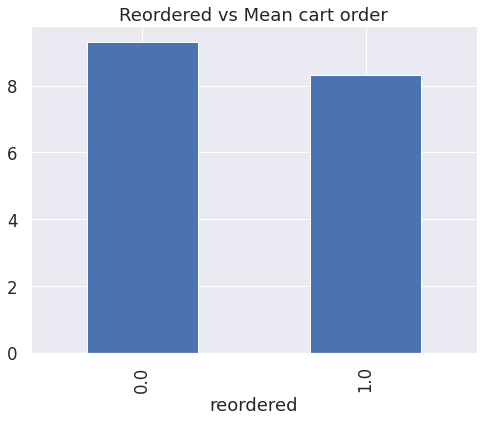

In [ ]:
print(train_df.groupby('reordered')['mean_cart_order'].mean())
plt.figure(figsize=(8, 6))
train_df.groupby('reordered')['mean_cart_order'].mean().plot.bar()
plt.title('Reordered vs Mean cart order')
plt.show()

마지막에 재구매된 제품들은 그렇지 않은 제품에 비해 장바구니 우선순위가 높다.

In [11]:
train_df.corr()

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,aisle_id,department_id,...,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1,reordered
user_id,1.000000,-0.000438,-0.001855,-0.000370,0.001015,0.000222,-0.001289,-0.000689,0.000029,-0.000012,...,-0.006227,0.001656,-0.009051,0.005580,0.003604,-0.003850,-0.010275,-0.005042,-0.006432,-0.000429
product_id,-0.000438,1.000000,0.003016,0.000223,0.003457,0.001557,-0.000685,0.003546,0.003723,-0.026408,...,-0.000466,0.004331,-0.001607,0.003348,0.003310,0.003650,-0.001380,-0.001184,-0.001070,0.002786
UP_total_reorders,-0.001855,0.003016,1.000000,-0.085359,0.319162,0.332147,0.272005,0.510366,0.003565,-0.032730,...,0.198953,0.052164,0.283968,0.047017,0.045773,0.042487,0.197016,0.188938,0.182988,0.248376
UP_mean_cart_order,-0.000370,0.000223,-0.085359,1.000000,-0.045288,-0.067959,-0.057155,-0.097955,0.006578,0.026551,...,0.301737,0.577289,0.145279,0.428114,0.425722,0.425622,0.097952,0.105294,0.108505,-0.042599
UP_order_-3,0.001015,0.003457,0.319162,-0.045288,1.000000,0.458468,0.250142,0.533683,0.006304,-0.037269,...,-0.185456,0.066078,-0.092890,0.084369,0.086730,0.090078,-0.111579,-0.088810,-0.074142,0.308757
UP_order_-2,0.000222,0.001557,0.332147,-0.067959,0.458468,1.000000,0.493969,0.774679,0.002758,-0.034766,...,-0.087403,0.066534,0.031881,0.073088,0.077813,0.075601,-0.031003,0.017064,0.046895,0.331994
UP_order_-1,-0.001289,-0.000685,0.272005,-0.057155,0.250142,0.493969,1.000000,0.504716,-0.001747,-0.020606,...,-0.041078,0.044852,0.060401,0.049324,0.048810,0.050479,0.012321,0.048218,0.055549,0.260547
UP_reorder_ratio,-0.000689,0.003546,0.510366,-0.097955,0.533683,0.774679,0.504716,1.000000,0.006778,-0.046870,...,-0.074146,0.090978,0.098122,0.073012,0.081807,0.079045,0.021631,0.051979,0.086343,0.373021
aisle_id,0.000029,0.003723,0.003565,0.006578,0.006304,0.002758,-0.001747,0.006778,1.000000,0.027501,...,0.004460,0.012318,-0.002780,0.008817,0.009806,0.009343,-0.001903,-0.002113,-0.002495,0.002256
department_id,-0.000012,-0.026408,-0.032730,0.026551,-0.037269,-0.034766,-0.020606,-0.046870,0.027501,1.000000,...,0.024408,0.014848,0.006554,0.011392,0.009631,0.009953,0.008930,0.005323,0.002395,-0.033707


# 3. 학습/예측/평가

위에서 생성한 `train_df, test_df`를 로드해서 사용

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.5)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

train_df = pd.read_pickle(PATH + 'train_df.pkl')
test_df = pd.read_pickle(PATH + 'test_df.pkl')

# 훈련 데이터와 타겟 분리
X = train_df.drop('reordered', axis=1)
y = train_df['reordered']

## 베이스라인

1. 모델 : LGBM 사용
2. CV : 유저별로 나눈 Kfold 사용.
3. 평가지표 : F1


1. train_df에서 타겟을 제외하고 X로, 타겟은 y로 나눈다.
2. CV을 위해 GroupKFold 그룹을 나누고 cross_val_predict로 예측값을 뽑는다.
3. precision_recall_curve로 threshold에 따라 precision과 recall의 변화를 확인한다. 적절한 threshold를 찾는다. 
4. 찾은 threshold를 사용해서 레이블을 예측하고 f1 score를 확인한다.


### CV로 threshold 찾기

In [12]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score

clf_lgbm = LGBMClassifier() # 모델

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

In [ ]:
y_scores = cross_val_predict(clf_lgbm, X, y, cv=gkf, method='predict_proba')
# y_scores

cross_val_predict로 교차검증을 통해서 레이블 확률을 뽑았다. 

0열이 0일 확률, 1열이 1일 확률이다.

1일 확률만 사용해서 precisions, recalls, thresholds를 뽑고 최적의 threshold 찾아보기

In [ ]:
# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

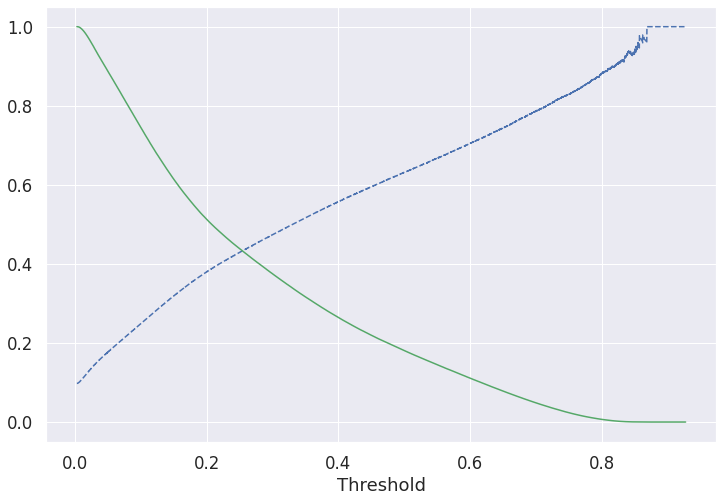

In [ ]:
# threshold에 따른 precision과 recall의 trade_off 확인하기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('Threshold')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

0.2와 0.3이 사이가 가장 좋아보인다. 정확하게 확인해본다.

In [ ]:
for thre in range(20, 30):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

treshold : 0.2 0.4364907975586209
treshold : 0.21 0.4370896911053219
treshold : 0.22 0.4371393364284061
treshold : 0.23 0.43644598980169713
treshold : 0.24 0.43530963384741833
treshold : 0.25 0.4337451817201162
treshold : 0.26 0.4316943940350686
treshold : 0.27 0.4290151887622374
treshold : 0.28 0.42613649156778416
treshold : 0.29 0.42259442330563557


0.22가 0.4371로 f1 score가 가장 높다.

In [ ]:
y_scores_22 = (y_scores[:, 1] >= 0.22).astype(np.uint8)
f1_score(y, y_scores_22)

0.4371393364284061

### 실제로 훈련하고 타겟값 뽑아내서 제출하기

In [ ]:
# 훈련
clf_lgbm.fit(X, y)

In [ ]:
# 예측
# predict_proba로 예측 확률을 뽑아낸다.

y_pred = clf_lgbm.predict_proba(test_df)
y_pred.shape

In [ ]:
# 위에서 찾은 threshold를 기준으로 타겟을 변환한다.
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)

threshold를 통과한 타겟을 이용해서 제출 형식에 맞추기 위해서 test 셋에 컬럼으로 추가해준다.

In [ ]:
# 데이터에 추가하기
test_df['reordered'] = final_y_pred

In [ ]:
test_df.head()

,user_id,product_id,UP_total_reorders,UP_first_order_num,UP_last_order_num,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,aisle_id,...,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1,reordered
120,3,39190,9,1,12,1.799805,1,1,1,91,...,19.0,7.332031,0.71875,6.0,5.0,6.0,0.833496,1.0,1.0,1
121,3,47766,8,1,12,3.777344,1,1,1,24,...,19.0,7.332031,0.71875,6.0,5.0,6.0,0.833496,1.0,1.0,1
122,3,21903,7,1,12,4.250000,1,1,-1,123,...,19.0,7.332031,0.71875,6.0,5.0,6.0,0.833496,1.0,1.0,1
123,3,9387,4,1,7,3.599609,-1,-1,-1,24,...,19.0,7.332031,0.71875,6.0,5.0,6.0,0.833496,1.0,1.0,0
124,3,17668,4,1,11,3.599609,1,1,-1,91,...,19.0,7.332031,0.71875,6.0,5.0,6.0,0.833496,1.0,1.0,1


### submission 생성/제출

1. orders에서 test셋의 order_id와 user_id만 뽑아서 'sub' 생성.
2. test_df에서 유저별로 reordered가 1인 product_id를 뽑고 공백으로 구분된 하나의 문자열로 생성.
3. user_id에 맞춰서 'sub'에 병합

In [ ]:
sample = pd.read_csv(PATH + 'sample_submission.csv')
sample.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


#### 1. 테스트셋 유저와 order_id 뽑기

In [ ]:
orders = pd.read_pickle(PATH + 'orders.pkl')

In [ ]:
# 1. 테스트셋 유저와 주문 번호 뽑기
sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)
sub.head()

,order_id,user_id
0,2774568,3
1,329954,4
2,1528013,6
3,1376945,11
4,1356845,12


#### 2. 유저별로 reordered 1인 제품 문자열로 합치기

##### (test) 문자열 생성 



유저 1개만 잡고 test

In [ ]:
# 조건 걸어서 product_id뽑고 문자열로 변환
test_prod_id = ' '.join(map(str, test_df[(test_df.user_id == 3) & (test_df.reordered == 1)]['product_id']))
test_prod_id

'39190 47766 21903 17668 18599 43961 32402 23650'

In [ ]:
# sub에 컬럼으로 추가
sub['product_id'] = test_prod_id
sub.head()

,order_id,user_id,product_id
0,2774568,3,39190 47766 21903 17668 18599 43961 32402 23650
1,329954,4,39190 47766 21903 17668 18599 43961 32402 23650
2,1528013,6,39190 47766 21903 17668 18599 43961 32402 23650
3,1376945,11,39190 47766 21903 17668 18599 43961 32402 23650
4,1356845,12,39190 47766 21903 17668 18599 43961 32402 23650


##### 전체 df에 적용

In [ ]:
# reordered가 1인 product_id만 문자열로 변환
# reordered가 1인 제품이 없는 유저는 이 df에는 포함되지 않는다. 
sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()
sub_prods.head()

,user_id,product_id
0,3,39190 47766 21903 17668 18599 43961 32402 23650
1,6,21903 38293
2,11,8309 27959 14947 28465 34658 33572 44632 13176
3,12,7076 10863 13176 14992
4,15,14715 12427 10441 27839 196 48142


#### 3. sub에 병합후 저장

In [ ]:
# sub에 병합한다. 위에서 포함되지 않는 user는 병합시 결측치가 된다. 
sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub

,order_id,product_id
0,2774568,39190 47766 21903 17668 18599 43961 32402 23650
1,329954,None
2,1528013,21903 38293
3,1376945,8309 27959 14947 28465 34658 33572 44632 13176
4,1356845,7076 10863 13176 14992
...,...,...
74995,2728930,2693 24852 432 38837 12919 17038 17459 41177
74996,350108,30561 43961 5646 10199 15649 21137 49075
74997,1043943,11520 27086
74998,2821651,44632 3397 13176 36011 33787 39180 27966 11068...


In [ ]:
# 서브미션 저장
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

#### 캐글 API 키를 사용해서 바로 submit하기

In [ ]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "first my base_model!"

/content/drive/MyDrive
/content
100% 3.73M/3.73M [00:02<00:00, 1.70MB/s]
Successfully submitted to Instacart Market Basket Analysis

5/24 베이스라인 서브미션 결과
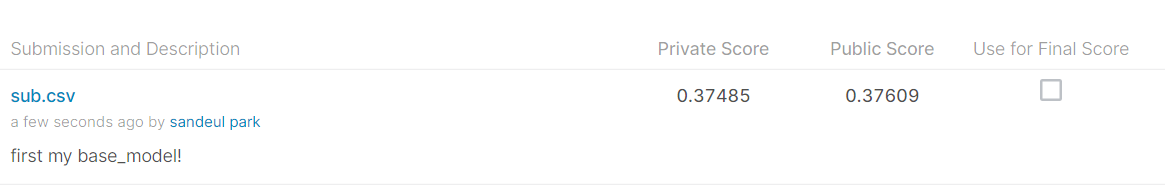

5/24 CV score
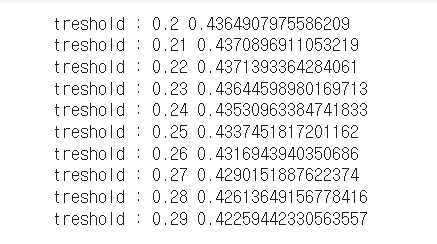

## catboost 베이스라인

In [3]:
# !pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score

clf_CB = CatBoostClassifier(task_type = "GPU") # 모델

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 100 kB/s 


In [ ]:
# predict score뽑기
y_scores = cross_val_predict(clf_CB, X, y, cv=gkf, method='predict_proba')

In [ ]:
# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

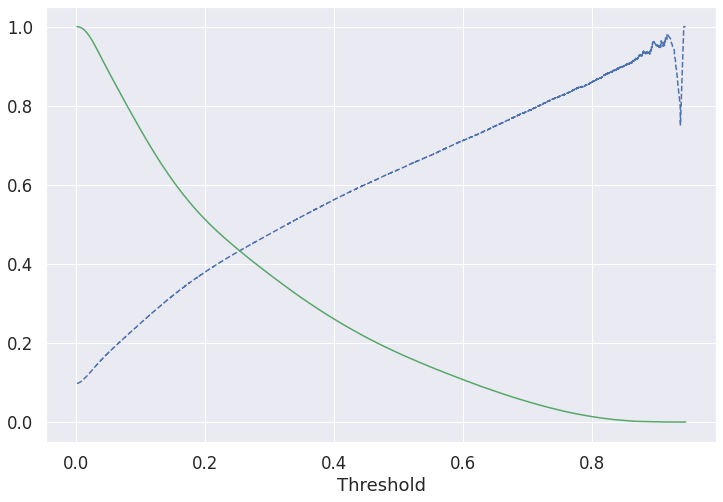

In [ ]:
# threshold에 따른 precision과 recall의 trade_off 확인하기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('Threshold')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
for thre in range(20, 30):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

threshold : 0.2 0.4360892899929764
threshold : 0.21 0.4367604524144036
threshold : 0.22 0.43694139485838873
threshold : 0.23 0.4363913327885959
threshold : 0.24 0.4354584827457738
threshold : 0.25 0.43386457996817307
threshold : 0.26 0.4316495248014582
threshold : 0.27 0.42889143381245926
threshold : 0.28 0.42574256786632975
threshold : 0.29 0.42220465111359107


In [ ]:
clf_CB = CatBoostClassifier(learning_rate=0.1,max_depth = 10,n_estimators = 100,class_weights ={0: 1, 1: 4},task_type = "GPU",verbose = False)
clf_CB.fit(X, y)

y_pred = clf_CB.predict_proba(test_df)
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)
test_df['reordered'] = final_y_pred

### submission 생성/제출

In [ ]:
orders = pd.read_pickle(PATH + 'orders.pkl')

sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)

sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()

sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

#### 캐글 API 키를 사용해서 바로 submit하기

In [ ]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "base_model_catboost"

/content/drive/MyDrive
/content
100% 11.5M/11.5M [00:02<00:00, 5.79MB/s]
Successfully submitted to Instacart Market Basket Analysis

5/14 리더보드 점수
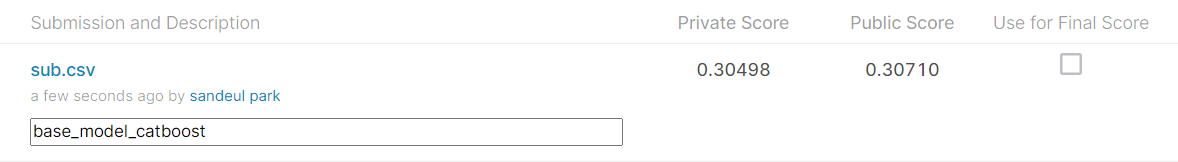

### 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

CBC = CatBoostClassifier(task_type = "GPU") # task_type = "GPU"

GKF = GroupKFold(n_splits=2)  # Group KFold
GKF = GKF.split(X, y, groups=X['user_id'].values)

parameters = {'depth'         : [4,5,6,7,8,9, 10], 
              'learning_rate' : [0.01,0.02,0.03,0.04], 
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

# n_jobs=-1 = using all processors
# verbose = Controls the verbosity: the higher, the more messages 
Grid_CBC = GridSearchCV(estimator=CBC, 
                        param_grid=parameters, 
                        cv=GKF, 
                        n_jobs=-1, 
                        scoring='f1',
                        verbose=3)
Grid_CBC.fit(X, y)

CatBoost 

1. 카테고리컬 피쳐 명은 리스트로 저장해둔다. 

# 5/25

user_product_feats에 reorder_ratio 피쳐 추가했다. 

catboost로 확인해 보니 cv에서는 `treshold : 0.22 0.4371`에서 `threshold : 0.22 0.4346`으로 떨어졌다. 

리더보드는 이전에 제출한 결과는 파라미터를 만지고 예측한 거라 점수가 크게 차이난다.

## catboost

### CV

In [ ]:
# !pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score

clf_CB = CatBoostClassifier(task_type = "GPU") # 모델

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

# predict score뽑기
y_scores = cross_val_predict(clf_CB, X, y, cv=gkf, method='predict_proba')

# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

In [11]:
for thre in range(20, 25):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

threshold : 0.2 0.4335358199576019
threshold : 0.21 0.43448897661039965
threshold : 0.22 0.434638492044926
threshold : 0.23 0.4342566296610482
threshold : 0.24 0.4332329349508391


### 리더보드

In [ ]:
# !pip install catboost
from catboost import CatBoostClassifier

orders = pd.read_pickle(PATH + 'orders.pkl')

clf_CB = CatBoostClassifier(task_type = "GPU") # 모델
clf_CB.fit(X, y)

y_pred = clf_CB.predict_proba(test_df)
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)
test_df['reordered'] = final_y_pred

sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)
sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()

sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

#### 캐글 API 키를 사용해서 바로 submit하기

In [7]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "after_reorder_ratio_feats_catboost"

/content/drive/MyDrive
/content
100% 3.71M/3.71M [00:04<00:00, 887kB/s]
Successfully submitted to Instacart Market Basket Analysis

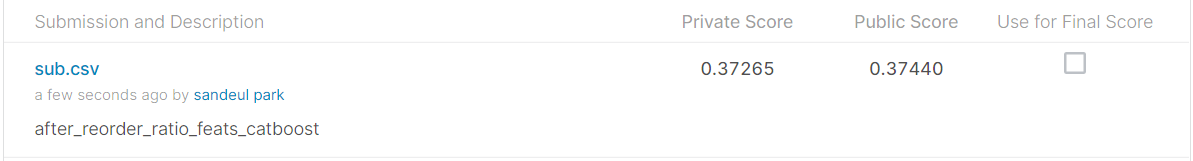

## aisle과 department 피쳐 추가